In [19]:
import matplotlib.pyplot as plt
import numpy as np
import emcee
import corner
import scipy.stats
from scipy.stats import bernoulli
import tqdm

thefigsize = (5,5)
intcnt = 50
tt = 500

### Exercise 64

In [20]:
def cal_grad(theta,beta):
    ll = len(theta)
    grad = np.zeros(ll)
    for i in range(ll):
        grad[i] = -2*beta*(np.sin(theta[i]-theta[(i-1)%ll])+np.sin(theta[i]-theta[(i+1)%ll]))
    return grad

# Equation 5.9
def od_langevin(theta,beta,h):
    ll = len(theta)
    xi = np.random.randint(0,2,ll)*2-1
    theta += h*cal_grad(theta,beta)+np.sqrt(2*h)*xi
    theta = (theta+np.pi)%(2*np.pi)-np.pi
    return theta

def XY_model(ll):
    theta = np.random.rand(ll)*2*np.pi-np.pi
    return theta

def l_prob(y,x,h,beta):
    aa = y-x-h*cal_grad(x,beta)
    return np.exp(-aa.dot(aa)/(4*h))

def pi(theta,beta,ll):
    cal = 0
    for i in range(ll):
        cal += np.cos(theta[i]-theta[(i-1)%ll])+np.cos(theta[i]-theta[(i+1)%ll])
    return np.exp(beta*cal)

def complete_od_langevin(ll,beta,h,flag):
    stepsize = int(divmod(tt,h)[0])
    his_lst = []
    x = XY_model(ll)
    for i in range(stepsize):
        newx = od_langevin(x,beta,h)
        if flag == False:
            x = newx
        else:
            p_acc = (l_prob(x,newx,h,beta)*pi(newx,beta,ll))/(l_prob(newx,x,h,beta)*pi(x,beta,ll))
            if np.random.random() < min(1,p_acc):
                x = newx
        a = np.sum(np.array([np.cos(x),np.sin(x)]),axis=1)
        his_lst.append(a[0]/np.linalg.norm(a))
    return his_lst


#### different h value

In [21]:
hlst = np.linspace(10**(-2.5),10**(-1),intcnt)
beta = 0.1
L = 10
at1 = [] 
at2 = []
ref = []

for hval in hlst:
    his_lst = complete_od_langevin(L,beta,hval,flag=False)
    at1.append(emcee.autocorr.integrated_time(his_lst,quiet=True))
    his_lst = complete_od_langevin(L,beta,hval,flag=True)
    at2.append(emcee.autocorr.integrated_time(his_lst,quiet=True))
    ref.append(1/hval)

/var/folders/xw/612lbhl95cx1vbrp3tfqjjlw0000gn/T/ipykernel_31029/1896410595.py:39: RuntimeWarning: invalid value encountered in double_scalars
  p_acc = (l_prob(x,newx,h,beta)*pi(newx,beta,ll))/(l_prob(newx,x,h,beta)*pi(x,beta,ll))


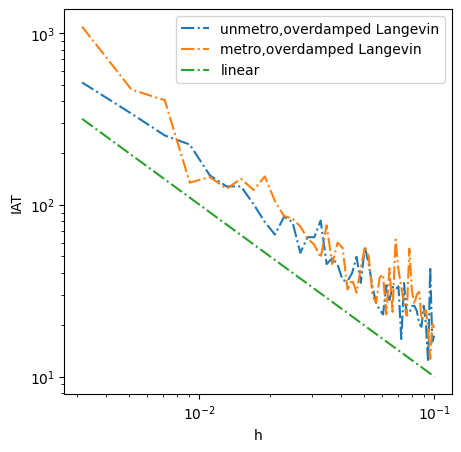

In [22]:
plt.figure(figsize=thefigsize)
plt.plot(hlst,at1,linestyle='-.',label='unmetro,overdamped Langevin')
plt.plot(hlst,at2,linestyle='-.',label='metro,overdamped Langevin')
plt.plot(hlst,ref,linestyle='-.',label='linear')
plt.xlabel('h')
plt.ylabel('IAT')
plt.xscale('log')
plt.yscale('log')
plt.legend()

#### different lattice size

In [23]:
beta = 0.1
Llst = np.linspace(5,50,10,dtype=int)
h = 10**(-1)
at1 = [] 
at2 = []

for Lval in Llst:
    his_lst = complete_od_langevin(Lval,beta,hval,flag=False)
    at1.append(emcee.autocorr.integrated_time(his_lst,quiet=True))
    his_lst = complete_od_langevin(Lval,beta,hval,flag=True)
    at2.append(emcee.autocorr.integrated_time(his_lst,quiet=True))

/var/folders/xw/612lbhl95cx1vbrp3tfqjjlw0000gn/T/ipykernel_31029/1896410595.py:39: RuntimeWarning: invalid value encountered in double_scalars
  p_acc = (l_prob(x,newx,h,beta)*pi(newx,beta,ll))/(l_prob(newx,x,h,beta)*pi(x,beta,ll))


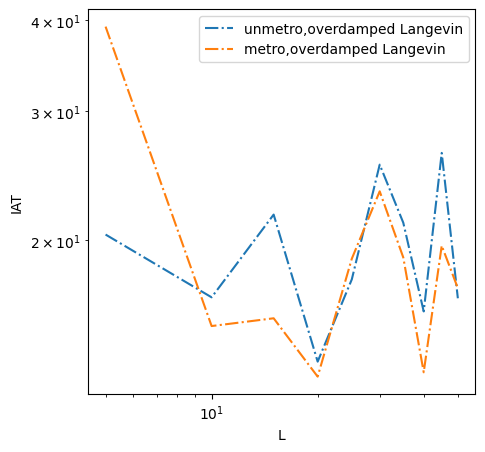

In [24]:
plt.figure(figsize=thefigsize)
plt.plot(Llst,at1,linestyle='-.',label='unmetro,overdamped Langevin')
plt.plot(Llst,at2,linestyle='-.',label='metro,overdamped Langevin')
plt.xlabel('L')
plt.ylabel('IAT')
plt.xscale('log')
plt.yscale('log')
plt.legend()

### Exercise 65

Here we choose $K(y)=\frac{y^2}{2}, \hat{J} = \mathbf{1}, h=10^{-2},n=5$, but we could also try other values of $n$.

In [25]:
# by algorithm 4, hybrid monte carlo
def h_pi(x,y,beta,ll):
    return pi(x,beta,ll)*np.exp(-np.sum(y**2)/2)

In [26]:
def h_move(x,y,beta,h,n):
    copyx = x.copy()
    copyy = y.copy()
    for i in range(n):
        copyy += h/2*cal_grad(copyx,beta)
        copyx += h*copyy
        copyy += h/2*cal_grad(copyx,beta)
    return copyx,copyy

def h_mc(ll,beta,h,n,flag):
    stepsize = int(divmod(tt,h)[0])
    his_lst = []
    x = XY_model(ll)
    for i in range(stepsize):
        y = np.random.normal(size=ll)
        newx,newy = h_move(x,y,beta,h,n)
        if flag == False:
            x = newx
        else:
            p_acc = h_pi(newx,newy,beta,ll)/h_pi(x,y,beta,ll)
            if np.random.random() < min(1,p_acc):
                x = newx            
        a = np.sum(np.array([np.cos(x),np.sin(x)]),axis=1)
        his_lst.append(a[0]/np.linalg.norm(a))
    return his_lst

In [27]:
hlst = np.linspace(10**(-2.5),10**(-1),intcnt)
beta = 0.1
L = 10
n = 5
at1 = [] 
at2 = []
ref = []

for hval in hlst:
    his_lst = h_mc(L,beta,hval,n,flag=False)
    at1.append(emcee.autocorr.integrated_time(his_lst,quiet=True))
    his_lst = h_mc(L,beta,hval,n,flag=True)
    at2.append(emcee.autocorr.integrated_time(his_lst,quiet=True))
    ref.append(1/hval)

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 3162;
tau: [9576.51236515]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 3162;
tau: [3640.96654309]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1946;
tau: [4091.67076949]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1406;
tau: [2731.71480562]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1406;
tau: [3277.53397186]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this 

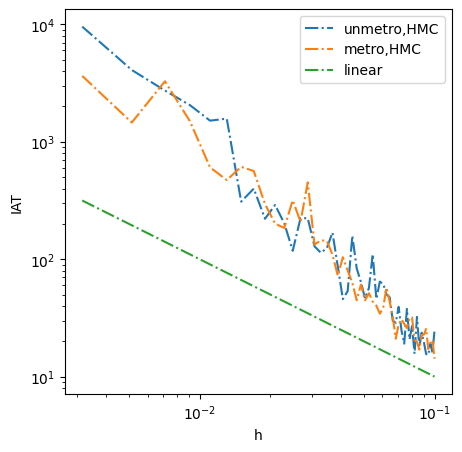

In [28]:
plt.figure(figsize=thefigsize)
plt.plot(hlst,at1,linestyle='-.',label='unmetro,HMC')
plt.plot(hlst,at2,linestyle='-.',label='metro,HMC')
plt.plot(hlst,ref,linestyle='-.',label='linear')
plt.xlabel('h')
plt.ylabel('IAT')
plt.xscale('log')
plt.yscale('log')
plt.legend()

### Exercise 66

Here we choose $K(y)=\frac{y^2}{2}, \hat{J} = \mathbf{1}, h=10^{-2},\gamma=0.1$, but we could also try other values of $n$.

In [29]:
# P112 in Lec 5
def u_move(x,y,beta,gamma,h):
    newx = x
    newy = y
    newy += (h/2)*cal_grad(newx,beta)
    newx += (h/2)*newy
    xi = np.random.randint(0,2,len(newy))*2-1
    newy = np.exp(-gamma*h)*newy+np.sqrt(1-np.exp(-2*gamma*h))*xi
    newx += (h/2)*newy
    newy += (h/2)*cal_grad(newx,beta)
    return newx,newy

# P119
def cal_r(x,y,newx,newy,gamma,h):
    cc = newy-np.exp(-gamma*h)*y-h/2*(np.exp(-gamma*h)*cal_grad(x,beta)+cal_grad(newx,beta))
    pp = -np.linalg.norm(cc)**2/(2*(1-np.exp(-2*gamma*h)))
    return np.exp(pp)

# Algorithm 6
def u_langevin(ll,beta,gamma,h,flag):
    stepsize = int(divmod(tt,h)[0])
    his_lst = []
    x = XY_model(ll)
    y = np.random.normal()
    for i in range(stepsize):
        newx,newy = u_move(x,y,beta,gamma,h)
        if flag == False:
            x = newx
            y = newy
        else:
            p_acc = (h_pi(newx,newy,beta,ll)*cal_r(newx,-newy,x,-y,gamma,h)/(h_pi(x,y,beta,ll)*cal_r(x,y,newx,newy,gamma,h)))
            if np.random.random() < min(1,p_acc):
                x = newx
                y = newy
            else:
                y = -y            
        a = np.sum(np.array([np.cos(x),np.sin(x)]),axis=1)
        his_lst.append(a[0]/np.linalg.norm(a))
    return his_lst

In [30]:
hlst = np.linspace(10**(-2.5),10**(0),intcnt)
beta = 0.1
L = 10
gamma = 1
at1 = [] 
at2 = []
ref = []

for hval in hlst:
    his_lst = u_langevin(L,beta,gamma,hval,flag=False)
    at1.append(emcee.autocorr.integrated_time(his_lst,quiet=True))
    his_lst = u_langevin(L,beta,gamma,hval,flag=True)
    at2.append(emcee.autocorr.integrated_time(his_lst,quiet=True))
    ref.append(1/hval)

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 425;
tau: [838.9275981]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 80;
tau: [350.15057352]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 32;
tau: [60.67960374]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 32;
tau: [126.40586901]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 30;
tau: [190.5470718]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with cau

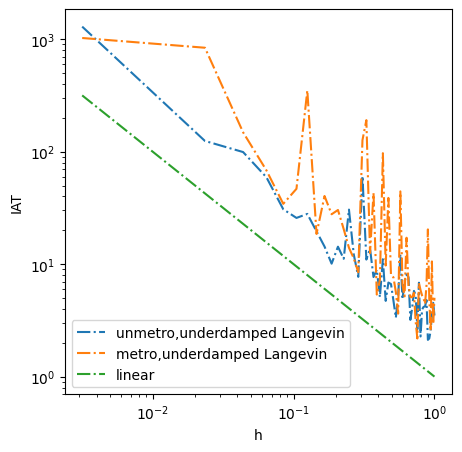

In [31]:
plt.figure(figsize=thefigsize)
plt.plot(hlst,at1,linestyle='-.',label='unmetro,underdamped Langevin')
plt.plot(hlst,at2,linestyle='-.',label='metro,underdamped Langevin')
plt.plot(hlst,ref,linestyle='-.',label='linear')
plt.xlabel('h')
plt.ylabel('IAT')
plt.xscale('log')
plt.yscale('log')
plt.legend()

In [32]:
gamma_lst = np.linspace(0.1,1,intcnt)
beta = 0.1
L = 10
h = 10**(-1)
at1 = [] 
at2 = []

for gamma in gamma_lst:
    his_lst = u_langevin(L,beta,gamma,h,flag=False)
    at1.append(emcee.autocorr.integrated_time(his_lst,quiet=True))
    his_lst = u_langevin(L,beta,gamma,h,flag=True)
    at2.append(emcee.autocorr.integrated_time(his_lst,quiet=True))

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 100;
tau: [257.97075634]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 100;
tau: [343.47611324]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 100;
tau: [113.23922471]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 100;
tau: [420.20756802]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 100;
tau: [434.96469242]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate w

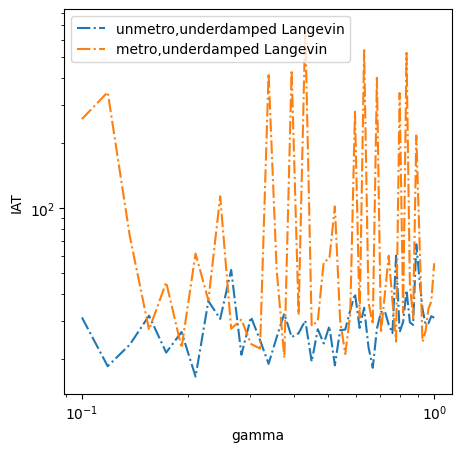

In [33]:
plt.figure(figsize=thefigsize)
plt.plot(gamma_lst,at1,linestyle='-.',label='unmetro,underdamped Langevin')
plt.plot(gamma_lst,at2,linestyle='-.',label='metro,underdamped Langevin')
plt.xlabel('gamma')
plt.ylabel('IAT')
plt.xscale('log')
plt.yscale('log')
plt.legend()